This document is to study the phenomena of energy splitting
Show in a very clear way how branching causes the space in which the worlds are defined to not split in 2.
Show how this responds to adding a self interaction term.

In [1]:
import sys
import os

# modify syspath directory to sys.path

package_path = os.path.abspath(os.path.join('..','core'))
if package_path not in sys.path:
    sys.path.append(package_path)

package_path = os.path.abspath(os.path.join('..','utils'))
if package_path not in sys.path:
    sys.path.append(package_path)

package_path = os.path.abspath(os.path.join('..'))
if package_path not in sys.path:
    sys.path.append(package_path)

import numpy as np
import qutip as qt
import math
import matplotlib.pyplot as plt

from IPython.display import HTML # both needed to disply gifs
from PIL import Image

# Import modules from the package
from core import create_hamiltonian as ch
from core import create_state as cs
from core import create_coherent_state
from core import time_evo
from core import time_evo_new
from core import time_evo_from_state
from core import load_param
from core import load_H_list
from core import load_result
from core import load_tlist
from core import operators
from core.schmidt_solve import compute_schmidt_states_all_time
from core.eigen_ener_states import eigen_ener_states as eig
from core import annihilation_operator
from utils.entropy import compute_VN, plot_VN, compute_VN_time
from utils import collapse_gif
from utils.collapse_gif import collapse_gif
from utils.display_gif import display_gif
from utils.distribution_gif import gif_distribution_eig_total
from utils.distribution_gif import prob_gif
from utils.distribution_gif import gif_distrib_H_s_int
from utils.distribution_gif import gif_distrib_system_first_eig
from utils.plot import plot_basic
from utils.plot import plot_with_binning
from utils.basic_functions import state_distribution_eig_tot
from utils.basic_functions import random_dephasing
from utils.basic_functions import get_state_probabilities
from utils.basic_functions import position
from utils.basic_functions import copy_cat
from utils.overlap import overlap
from utils.overlap import gif_schmidt_overlap
from utils.interference import interference_plot
from utils.expectations import exp_val_time
from utils.plot_hamiltonians import plot_hamiltonians



<h3>Exploring energy splitting in the context of a coherent state<h3>

In [2]:
file_name = "coherent_state_decoherence"

d1, d2, E_s, E_s2, E_int_s, E_int_e, E_int_s2, E_int_e2, E_e, E_e2, envi, tmax, ind_nb, log = load_param(file_name)
info = load_param(file_name)
H_list=load_H_list(file_name)
result=load_result(file_name)
tlist=load_tlist(file_name)


In [3]:
eigen = eig(H_list)


In [4]:
s_list = compute_schmidt_states_all_time(result, ind_nb)
ss_list = s_list[0]
se_list= s_list[1]
sv_list = s_list[2]
s_full_list=s_list[3]

In [12]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from PIL import Image

def update(frames,result,eigenstates_total,eigenenergies_total,s_full_list,zoom,x,y):
    
    # Clear previous plot
    frames=frames+1
    plt.clf()

    state = s_full_list[frames][0]
    state2 = s_full_list[frames][1]
    energy_coeff=[abs(np.vdot(state, eigenstate)) ** 2 for eigenstate in eigenstates_total]
    energy_coeff2=[abs(np.vdot(state2, eigenstate)) ** 2 for eigenstate in eigenstates_total]
    if zoom == True:
        plt.plot(eigenenergies_total, energy_coeff)
        plt.plot(eigenenergies_total, energy_coeff2)
        plt.title(f"Plot of the probability that Schmidt1 and 2 are in the total energy eigenstates")
        plt.xlabel("Eigenenergies of H_total")
        plt.ylabel("Probabilities")
        plt.ylim(y[0], y[1])
        plt.xlim(x[0], x[1])
    else:
        plt.plot(eigenenergies_total, energy_coeff)
        plt.plot(eigenenergies_total, energy_coeff2)
        plt.title(f"Plot of the probability that Schmidt1 and 2 are in the total energy eigenstates")
        plt.xlabel("Eigenenergies of H_total")
        plt.ylabel("Probabilities")
        plt.ylim(0, 0.35)
    
    # Calculate the mean
    mean1 = np.sum(np.array(energy_coeff) * np.array(eigenenergies_total))
    mean2 = np.sum(np.array(energy_coeff2) * np.array(eigenenergies_total))
    st1_tst1 = np.mean((np.array(energy_coeff) * np.array(eigenenergies_total)-mean1)**2)
    st1_tst2 = np.mean((np.array(energy_coeff2) * np.array(eigenenergies_total)-mean2)**2)
    std1 = np.std(np.array(energy_coeff) * np.array(eigenenergies_total))
    std2 = np.std(np.array(energy_coeff2) * np.array(eigenenergies_total))
    # Add a vertical line at the mean for energy_coeff
    plt.axvline(x=mean1, color='b', linestyle='--')
    # Add a vertical line at the mean for energy_coeff2
    plt.axvline(x=mean2, color='r', linestyle='--')
    # Add a vertical line at the mean plus one standard deviation for energy_coeff
    plt.axvline(x=mean1 + st1_tst1, color='g', linestyle='--')
    # Add a vertical line at the mean minus one standard deviation for energy_coeff
    plt.axvline(x=mean1 - st1_tst1, color='g', linestyle='--')
    # Add a vertical line at the mean plus one standard deviation for energy_coeff2
    plt.axvline(x=mean2 + st1_tst2, color='c', linestyle='--')
    # Add a vertical line at the mean minus one standard deviation for energy_coeff2
    plt.axvline(x=mean2 - st1_tst2, color='c', linestyle='--')
    plt.legend(["Schmidt1", "Schmidt2", "Mean1", "Mean2", "Mean1 + Std1", "Mean1 - Std1", "Mean2 + Std2", "Mean2 - Std2"])
    # Add clock
    plt.text(0.95, 0.95, f"Frame: {frames}", horizontalalignment='left', verticalalignment='top', transform=plt.gca().transAxes)

def gif_distribution_eig_total(result,eig,s_list, name,ind_nb, zoom=False,x=[0,2],y=[0,0.05]): #EI,w,result,eigenstates_total,eigenenergies_total,env,d1,d2,E_spacing,tmax,ind_nb
    
    #Get the necessary information
    eigenstates_total=eig[1]
    eigenenergies_total=eig[0]

    s_full_list=s_list[3]
    
    # Create a figure
    fig = plt.figure(figsize=(10, 5))

    # Create the animation
    ani = FuncAnimation(fig, update,fargs=(result,eigenstates_total,eigenenergies_total,s_full_list,zoom,x,y), frames=ind_nb-1, interval=100)

    # Save the animation as a GIF
    path = f'../outputs/gifs/distrib_eig_total_{name}_zoom_{zoom}.gif'
    ani.save(path, writer='pillow')
    plt.close()

    return path


In [13]:
path = gif_distribution_eig_total(result,eigen,s_list,file_name,ind_nb, zoom=False,x=[0,2],y=[0,0.05])
display_gif(path)

In [14]:
path = gif_distribution_eig_total(result,eigen,s_list,file_name,ind_nb, zoom=True,x=[0,2],y=[0,0.05])
display_gif(path)

In [16]:
o1,o2,o3=overlap(tlist,result,H_list,s_list,eigen,info)

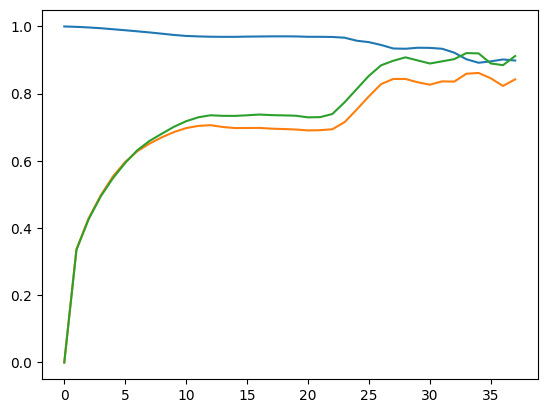

In [17]:
plt.plot(o1)
plt.plot(o2)
plt.plot(o3)

Start with finding a set of parameters where we get very clear and clean collapse.

In [2]:
# Setting parameters for simulation TODO make a config file for this.

d1 = 10; d2 = 200; E_spacing = 1.0; E_int = 0.075; E_int2 = 0; E_env = 1; E_env2 = 0; w = [0,0,0,np.sqrt(0.3),0,0,0,np.sqrt(0.7),0,0]; envi=[0]; tmax = 20; ind_nb = 100; log = 0
env_sys=0
# Running the simulation and running the core functions
result, tlist, H_list, ket_list, info = time_evo(d1,d2,E_spacing, E_int, E_int2, E_env, E_env2,w,envi, tmax, ind_nb,log)
eigen = eig(H_list)
s_list = compute_schmidt_states_all_time(result, ind_nb)
ss_list = s_list[0]
se_list= s_list[1]
sv_list = s_list[2]
s_full_list=s_list[3]

IndexError: list index out of range

These parameters correspond to a system + environment that has a decent collapse, as seen in the following gif

In [3]:
gif_path = collapse_gif(eigen, s_list, info,env_sys)
display_gif(gif_path)


We now see the variation in time of the distribution of the probabilities of Schmidt state 1 and 2 of being in the total energy eigenstates.

In [ ]:
path = gif_distribution_eig_total(result,eigen,s_list, info)
print(path)
display_gif(path)

The reason why we suspect that energy splitting is happening can be seen in a zoomed version of this gif. The initially overlapping distributions os Schmidt 1 and 2 evolve to barely share the energy eigenstates at all.

In [ ]:
path = gif_distribution_eig_total(result,eigen,s_list, info,True)
display_gif(path)

Another way of observing this is by looking at a plot of the sum of the product of the probabilities visible in the gif above. A set of 0's where the other is not zero would lead to a zero overlap.  

NameError: name 'mean' is not defined

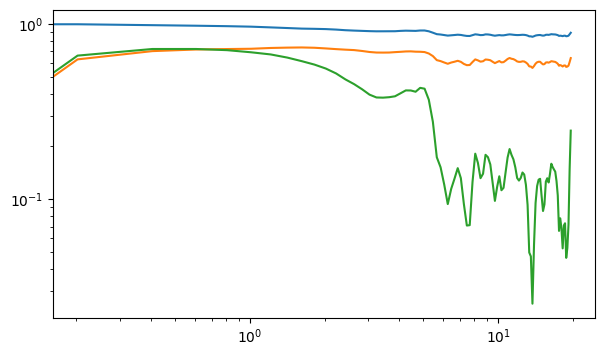

In [7]:
o01, o02, o12= overlap(tlist,result,H_list,s_list,eigen,info)
plt.figure(figsize=(7, 4))
plt.xscale("log")
plt.yscale("log")
plt.plot(tlist[0:len(tlist)-2],o01)
plt.plot(tlist[0:len(tlist)-2],o02)
plt.plot(tlist[0:len(tlist)-2],o12)
plt.title("Graph of the overlap of probabilities in the total energy eigenbasis")
plt.xlabel("Time")
plt.ylabel(r"$\vec{p}_i \cdot \vec{p}_j$")
plt.legend(['overlap Global-Schmidt 1', 'overlap Global-Schmidt 2', 'overlap Schmidt 1-Schmidt 2'])


Note, schmidrt states do have to be orthogonal, but they dont have to live in different subspaces to do so, and they usually wont. But here they do. there is a factor of 10 difference post decoherence in teh overlap between the 2 schmdit states when compared to the overlap between them and the environment. One would expect that E_env the environment self interaction if higher would cause better decoherence, leading to lower overlap, but no, it seems to become worse when going above 2. changing the dimension of the environment also does not seem to cause a lower overlap. Continue investigating the parameters.



In [ ]:
I will try to gif the overlaps. I should also add an averaging method to the overlap function

In [ ]:
path = gif_schmidt_overlap(eigen,s_list, info)
display_gif(path)

0.004903784237150637
0.004903784237150637
0.006731864963410276
0.006763115854857064
0.006012961732613416
0.004785404583264309
0.0033865834609741923
0.0025522156246268963
0.002029543805083897
0.0017339779167547661
0.0016374958572942864
0.0014519067902638795
0.0013541666174872367
0.0009704467869420056
0.0007446192569827239
0.0007617245443936731
0.00079329678534532
0.0006462681213500067
0.0003670225565492865
0.00019461032265417606
0.00012884057134097482
0.00015232902661832545
0.00014606720291155209
7.715163403771951e-05
4.7876832393507434e-06
4.067748989239713e-05
4.396659974772344e-05
6.562748914093328e-05
0.0003026712341295211
0.000553474581598297
0.0007786990426783071
0.0010104669020283862
0.001122179024026834
0.0011452658775465239
0.0010285690401174285
0.000637301335477591
0.0002237666377912337
8.38916075020162e-05
0.00014839845591826264
0.0002964772779391634
0.00034144775185564923
0.0002835847355348826
0.0002645108792613173
0.00041567964891970396
0.0006211994155580059
0.0005875182662